 ## CTA backtesting framework with BTCUSD and bollingerband strategy

 ## import packages

In [1]:
from ast import parse
from cmath import nan
from http.client import responses
import os
from re import S
from sqlite3 import PrepareProtocol
from tkinter import Grid
from tkinter.messagebox import NO
from tkinter.ttk import Style
from unittest.mock import NonCallableMagicMock
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import pandas_ta as pa

path = os.getcwd()
print(path)

/Users/abnerteng/GitHub/TMBA-projects/src


In [2]:
data = pd.read_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTC_funding.csv', parse_dates=True, index_col='time')

In [3]:
rule = '1D'
d1 = data.resample(rule = rule, closed = 'right', label = 'right').first()[['open']]
d2 = data.resample(rule = rule, closed = 'right', label = 'right').max()[['high']]
d3 = data.resample(rule = rule, closed = 'right', label = 'right').min()[['low']]
d4 = data.resample(rule = rule, closed = 'right', label = 'right').last()[['close']]
d5 = data.resample(rule = rule, closed = 'right', label = 'right').sum()[['volume']]

df = pd.concat([d1, d2, d3, d4, d5], axis = 1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2021-01-01 00:00:00+00:00,28795.5,29213.5,28320.0,29000.5,5.861939e+08
2021-01-02 00:00:00+00:00,29000.5,29731.0,28675.0,29385.0,1.190407e+09
2021-01-03 00:00:00+00:00,29385.0,33486.5,29028.0,32259.0,3.617095e+09


 ## strategy
 * Bollinger BandWidth
 * Dual Moving Average Crossover

 setting parameters

In [4]:
fund = 10000
money = 10000
feeRate = 0.0015
length = 20
times_of_std = 2

df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['shortSMA'] = df['close'].rolling(window = 13, center = False).mean()
df['longSMA'] = df['close'].rolling(window = 21, center = False).mean()

maxima_list = [0]
for i in range(len(df)):
    if df['close'][i] > df['close'][i-1]:
        maxima = df['close'][i]
    elif df['close'][i] < df['close'][i-1]:
        maxima = maxima
    maxima_list.append(maxima)
maxima_list = pd.DataFrame(maxima_list)
maxima_list = maxima_list.drop(0)
maxima_list = maxima_list.set_index(df.index)
df['maxima'] = maxima_list

minima_list = [0]
minima = df['close'][0]
for i in range(len(df)):
    if df['close'][i] < df['close'][i-1]:
        minima = df['close'][i]
    elif df['close'][i] > df['close'][i-1]:
        minima = minima
    minima_list.append(minima)
minima_list = pd.DataFrame(minima_list)
minima_list = minima_list.drop(0)
minima_list = minima_list.set_index(df.index)
df['minima'] = minima_list

In [5]:
upper_bound_list = [0]
lower_bound_list = [0]
BBW_list = [0]
threshold_list = [0]

for i in range(len(df)):
    upper_bound = df['ma'][i] + times_of_std * df['std'][i]
    upper_bound_list.append(upper_bound)

for i in  range(len(df)):
    lower_bound = df['ma'][i] - times_of_std * df['std'][i]
    lower_bound_list.append(lower_bound)

for i in range(len(df)):
    BBW = (upper_bound_list[i] - lower_bound_list[i]) / df['ma'][i]
    BBW_list.append(BBW)

for i in range(len(df)):
    threshold = 0.29
    threshold_list.append(threshold)

BBdata = pd.DataFrame([ upper_bound_list, lower_bound_list, BBW_list, threshold_list])
BBdata = pd.DataFrame.transpose(BBdata)
BBdata.columns = ['upper_bound', 'lower_bound', 'BBW', 'threshold']

BBdata = BBdata.drop(0)
BBdata = BBdata.set_index(df.index)

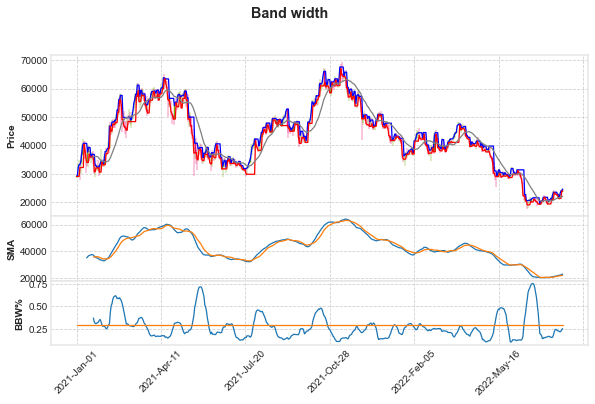

In [6]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['maxima'], color = 'blue'),
          mpf.make_addplot(df['minima'], color = 'red'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['shortSMA'], panel = 1, ylabel = 'SMA'),
          mpf.make_addplot(df['longSMA'], panel = 1, secondary_y = False),
          mpf.make_addplot(BBdata['BBW'], panel = 2, ylabel = 'BBW%'),
          mpf.make_addplot(BBdata['threshold'], panel = 2, secondary_y = False)
           ]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

 Include funding rate

In [7]:
rule = '1H'
df_hour = data.resample(rule = rule, closed = 'right', label = 'right').first()['open']
df_funding = pd.concat([df_hour, funding], axis = 1)
df_funding = df_funding.fillna(method = 'bfill', limit = 2).fillna(0)
df_funding

,open,rate
2020-12-31 16:00:00+00:00,28795.5,-0.000007
2020-12-31 17:00:00+00:00,28829.0,-0.000007
2020-12-31 18:00:00+00:00,28414.5,-0.000016
2020-12-31 19:00:00+00:00,28550.5,-0.000017
2020-12-31 20:00:00+00:00,28878.0,-0.000014
...,...,...
2022-07-30 12:00:00+00:00,23820.0,0.000007
2022-07-30 13:00:00+00:00,23966.0,0.000012
2022-07-30 14:00:00+00:00,24376.0,0.000013
2022-07-30 15:00:00+00:00,24490.0,0.000008


In [8]:
def fundingPayment(df_funding, side, unit, t1, t2):
    if len(df_funding.loc[t1:t2]) == 0:
        fee = 0
    else:
        funding_rate = np.array(df_funding.loc[t1:t2])
        fee = unit * np.dot(funding_rate[:,0], funding_rate[:,1])
    
    if side == 'long':
        return -fee
    elif side == 'short':
        return fee

                               profit    profitfee
startTime                                         
2021-01-01 00:00:00+00:00     0.00000     0.000000
2021-01-02 00:00:00+00:00     0.00000     0.000000
2021-01-03 00:00:00+00:00     0.00000     0.000000
2021-01-04 00:00:00+00:00     0.00000     0.000000
2021-01-05 00:00:00+00:00     0.00000     0.000000
...                               ...          ...
2022-07-27 00:00:00+00:00  8721.89142  7874.825463
2022-07-28 00:00:00+00:00  8721.89142  7874.825463
2022-07-29 00:00:00+00:00  8721.89142  7874.825463
2022-07-30 00:00:00+00:00  8721.89142  7874.825463
2022-07-31 00:00:00+00:00  8721.89142  7874.825463

[577 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

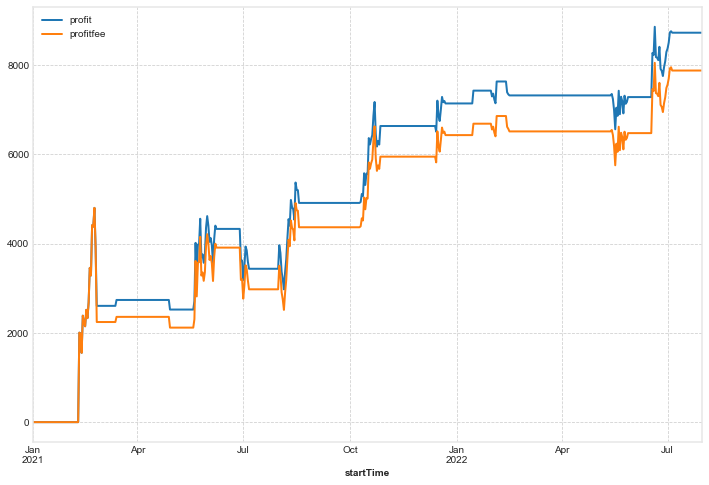

In [9]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] < df['longSMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
            t1 = df.index[i+1]
        
        if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] > df['longSMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)
            t1 = df.index[i+1]

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'long', executeSize, df.index[t], t2)

        if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] < df['longSMA'][i] or df['close'][i] <= df['maxima'][i]*0.89 or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'short', executeSize, df.index[t], t2)

        if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] > df['longSMA'][i] or df['close'][i] >= df['minima'][i]*1.11 or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [10]:
print(buy)
print(short)
print(sell)
print(buytocover)

[39, 211, 281, 407]
[71, 117, 138, 178, 346, 378, 394, 497, 532]
[55, 229, 299, 410]
[72, 118, 158, 186, 355, 379, 399, 512, 550]


In [11]:
equity['equity_value'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity_value'] / equity['equity_value'].cummax()) - 1
equity['drawdown'] = equity['equity_value'] - equity['equity_value'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

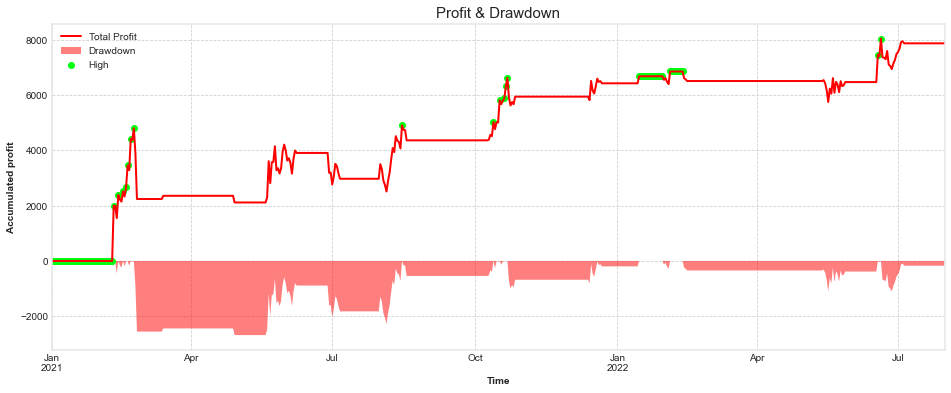

In [12]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

Text(0.5, 1.0, 'Price Movement')

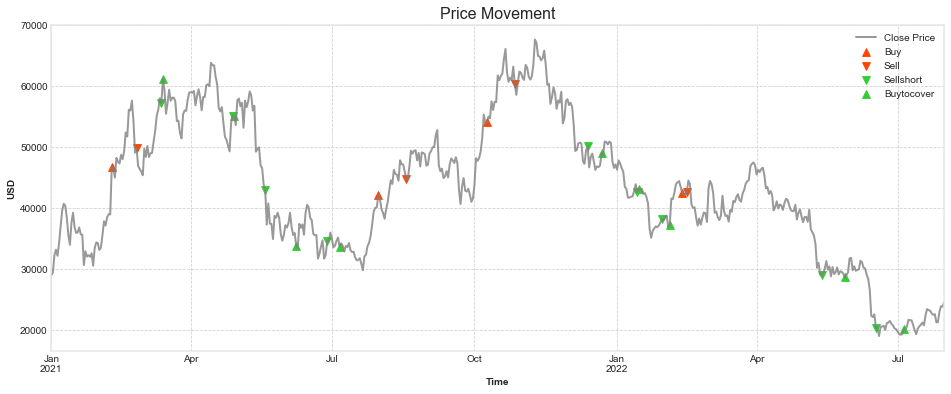

In [13]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16)

In [14]:
equity['unit_profit'] = profit_fee_list
daily_returns = [0]
for i in np.arange(1, len(equity), 1):
    dr = ((equity['equity_value'][i] - equity['equity_value'][i-1]) / equity['equity_value'][i-1])*100
    daily_returns.append(dr)
daily_returns = pd.DataFrame(daily_returns)
daily_returns = daily_returns.set_index(equity.index)
daily_returns.columns = ['daily_returns']
equity['daily_returns'] = daily_returns
equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
equity['downside_return'] = equity['downside_return'].fillna(0)

In [15]:
sqd_list = [0]
for i in np.arange(1, len(equity), 1):
    sqd = ((equity['daily_returns'][i] - np.mean(equity['daily_returns']))) ** 2
    sqd_list.append(sqd)
var = sum(sqd_list) / len(equity)
daily_vol = var ** 0.5
annual_vol = (252 ** 0.5) * daily_vol

In [16]:
equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
equity['downside_return'] = equity['downside_return'].fillna(0)
equity['downside_return'] = equity['downside_return'] / fund
dssqd_list = [0]
for i in np.arange(1, len(equity), 1):
    dssqd = (equity['downside_return'][i] - np.mean(equity['downside_return'])) ** 2
    dssqd_list.append(dssqd)
dsvar = sum(dssqd_list) / len(equity)
daily_dsvol = dsvar ** 0.5
dsvol = (len(equity) ** 0.5) * daily_dsvol

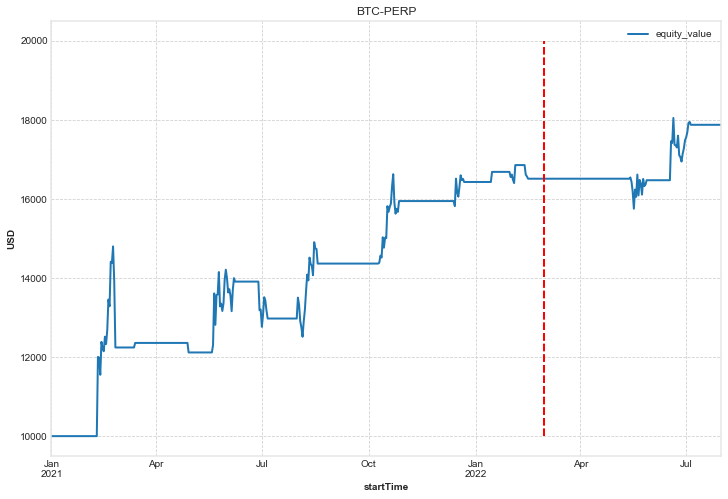

In [17]:
from datetime import datetime
ax = equity['equity_value'].plot(figsize = (12, 8), title = 'BTC-PERP', ylabel = 'USD')
ax.vlines(x=[datetime(2022, 3, 1), '2022-03-01'], ymin = 10000, ymax = 20000, color = 'r', linestyle = '--')
ax.legend()
plt.show()

In [18]:
profit = equity['profitfee'].iloc[-1] 
returns = (equity['equity_value'][-1] / equity['equity_value'][0])-1 ## cumulated return
mdd = abs(equity['drawdown_percent']).max() # mdd
calmarRatio = returns / mdd # risk return ratio
tradeTimes = len(buy) + len(short)
annual_returns = ((equity['equity_value'][-1] / 10000) ** (1 / (len(df) / 365)) - 1)*100
sharpe_ratio = annual_returns / annual_vol # sharpe ratio
sortino_ratio = returns / dsvol

In [19]:
print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}')
print(f'mdd: {np.round(mdd,4)}')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'annual_returns: {annual_returns}')
print(f'annual_volatility: {annual_vol}')
print(f'sharpe_ratio: {sharpe_ratio}')
print(f'sortino_ratio: {sortino_ratio}')

profit: $7874.83
returns: 0.7875
mdd: 0.1812
calmarRatio: 4.35
tradeTimes: 13
annual_returns: 44.398841814317834
annual_volatility: 26.124444311468633
sharpe_ratio: 1.6995133479193945
sortino_ratio: 2.6324957311841133


 ## Strategy optimize

In [20]:
df_insample = df.loc[:'2022-2']
df_outofsample = df.loc['2022-3':]

rule = '1D'
df_open = df['open']

 ## In-sample estimate

In [21]:
optimizationList = []
fund = 10000
money = 10000
feeRate = 0.0015

rule = '1D'

In [22]:
for sl_point in np.arange(0.05, 0.2, 0.01):
    for threshold in np.arange(0.1, 0.4, 0.01):
        print('----------')
        print(f'sl_point: {sl_point}')
        print(f'threshold: {threshold}')

        d1 = df_insample.resample(rule=rule, closed='right', label='right').first()[['open']]
        d2 = df_insample.resample(rule=rule, closed='right', label='right').max()[['high']]
        d3 = df_insample.resample(rule=rule, closed='right', label='right').min()[['low']]
        d4 = df_insample.resample(rule=rule, closed='right', label='right').last()[['close']]
        d5 = df_insample.resample(rule=rule, closed='right', label='right').sum()[['volume']]
        df = pd.concat([d1,d2,d3,d4,d5], axis=1)

        df['ma'] = df['close'].rolling(window = 20, center = False).mean()
        df['std'] = df['close'].rolling(window = 20, center = False).std()
        df['shortSMA'] = df['close'].rolling(window = 13, center = False).mean()
        df['longSMA'] = df['close'].rolling(window = 21, center = False).mean()

        maxima_list = [0]
        for i in range(len(df)):
            if df['close'][i] > df['close'][i-1]:
                maxima = df['close'][i]
            elif df['close'][i] < df['close'][i-1]:
                maxima = maxima
            maxima_list.append(maxima)
        maxima_list = pd.DataFrame(maxima_list)
        maxima_list = maxima_list.drop(0)
        maxima_list = maxima_list.set_index(df.index)
        df['maxima'] = maxima_list

        minima_list = [0]
        minima = df['close'][0]
        for i in range(len(df)):
            if df['close'][i] < df['close'][i-1]:
                minima = df['close'][i]
            elif df['close'][i] > df['close'][i-1]:
                minima = minima
            minima_list.append(minima)
        minima_list = pd.DataFrame(minima_list)
        minima_list = minima_list.drop(0)
        minima_list = minima_list.set_index(df.index)
        df['minima'] = minima_list

        upper_bound_list = [0]
        lower_bound_list = [0]
        BBW_list = [0]
        threshold_list = [0]
        spread_list = [0]

        for i in range(len(df)):
            upper_bound = df['ma'][i] + times_of_std * df['std'][i]
            upper_bound_list.append(upper_bound)

        for i in  range(len(df)):
            lower_bound = df['ma'][i] - times_of_std * df['std'][i]
            lower_bound_list.append(lower_bound)

        for i in range(len(df)):
            BBW = (upper_bound_list[i] - lower_bound_list[i]) / df['ma'][i]
            BBW_list.append(BBW)

        for i in range(len(df)):
            threshold = threshold
            threshold_list.append(threshold)

        BBdata = pd.DataFrame([upper_bound_list, lower_bound_list, BBW_list, threshold_list])
        BBdata = pd.DataFrame.transpose(BBdata)
        BBdata.columns = ['upper_bound', 'lower_bound', 'BBW', 'threshold']

        BBdata = BBdata.drop(0)
        BBdata = BBdata.set_index(df.index)

        B_or_S = None
        buy = []
        sell = []
        short = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]

        for i in range(len(df)):

            if i == len(df) - 1:
                break

            if B_or_S == None:
                profit_list.append(0)
                profit_fee_list.append(0)

                if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] < df['longSMA'][i]:
                    executeSize = money / df['open'][i+1]
                    B_or_S = 'S'
                    t = i + 1
                    short.append(t)
                    t1 = df.index[i+1]
        
                if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] > df['longSMA'][i]:
                    executeSize = money / df['open'][i+1]
                    B_or_S = 'B'
                    t = i + 1
                    buy.append(t)
                    t1 = df.index[i+1]

            elif B_or_S == 'B':
                profit = executeSize * (df['open'][i+1] - df['open'][i])
                profit_list.append(profit)
                t2 = df.index[i+1]
                fundingFee = fundingPayment(df_funding, 'long', executeSize, df.index[t], t2)

                if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] < df['longSMA'][i] or df['close'][i] <= df['maxima'][i]*(1 - sl_point) or (i == len(df) - 2):
                    pl_round = executeSize * (df['open'][i+1] - df['open'][t])
                    profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    B_or_S = None
        
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
                    t1 = df.index[i+1]

            elif B_or_S == 'S':
                profit = executeSize * (df['open'][i] - df['open'][i+1])
                profit_list.append(profit)
                t2 = df.index[i+1]
                fundingFee = fundingPayment(df_funding, 'short', executeSize, df.index[t], t2)

                if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] > df['longSMA'][i] or df['close'][i] > df['minima'][i]*(1 + sl_point) or(i == len(df) - 2):
                    pl_round = executeSize * (df['open'][t] - df['open'][i+1])
                    profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    B_or_S = None
        
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
                    t1 = df.index[i+1]

        equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)

        equity['equity_value'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity_value'] / equity['equity_value'].cummax()) - 1
        equity['drawdown'] = equity['equity_value'] - equity['equity_value'].cummax()

        equity['unit_profit'] = profit_fee_list
        daily_returns = [0]
        for i in np.arange(1, len(equity), 1):
            dr = (equity['equity_value'][i] - equity['equity_value'][i-1]) / equity['equity_value'][i-1]
            daily_returns.append(dr)
        daily_returns = pd.DataFrame(daily_returns)
        daily_returns = daily_returns.set_index(equity.index)
        daily_returns.columns = ['daily_returns']
        equity['daily_returns'] = daily_returns
        equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
        equity['downside_return'] = equity['downside_return'].fillna(0)

        sqd_list = [0]
        for i in np.arange(1, len(equity), 1):
            sqd = ((equity['daily_returns'][i] - np.mean(equity['daily_returns']))) ** 2
            sqd_list.append(sqd)
        var = sum(sqd_list) / len(equity)
        daily_vol = var ** 0.5
        annual_vol = (252 ** 0.5) * daily_vol

        equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
        equity['downside_return'] = equity['downside_return'].fillna(0)
        equity['downside_return'] = equity['downside_return'] / fund
        dssqd_list = [0]
        for i in np.arange(1, len(equity), 1):
            dssqd = (equity['downside_return'][i] - np.mean(equity['downside_return'])) ** 2
            dssqd_list.append(dssqd)
        dsvar = sum(dssqd_list) / len(equity)
        daily_dsvol = dsvar ** 0.5
        dsvol = (len(equity) ** 0.5) * daily_dsvol

        profit = equity['profitfee'].iloc[-1] 
        returns = (equity['equity_value'][-1] / equity['equity_value'][0]) - 1 ## cumulated return
        mdd = abs(equity['drawdown_percent']).max() # mdd
        calmarRatio = returns / mdd # risk return ratio
        tradeTimes = len(buy) + len(short)
        annual_returns = ((equity['equity_value'][-1] / 10000) ** (1 / (len(df) / 365)) - 1)*100
        sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
        sortino_ratio = returns / dsvol

        optimizationList.append([sl_point, threshold, profit, returns, mdd, calmarRatio, tradeTimes, annual_returns, annual_vol, sharpe_ratio, sortino_ratio])

----------
sl_point: 0.05
threshold: 0.1
----------
sl_point: 0.05
threshold: 0.11
----------
sl_point: 0.05
threshold: 0.12
----------
sl_point: 0.05
threshold: 0.13


<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.05
threshold: 0.13999999999999999
----------
sl_point: 0.05
threshold: 0.14999999999999997
----------
sl_point: 0.05
threshold: 0.15999999999999998
----------
sl_point: 0.05
threshold: 0.16999999999999998
----------
sl_point: 0.05
threshold: 0.17999999999999997
----------
sl_point: 0.05
threshold: 0.18999999999999995
----------
sl_point: 0.05
threshold: 0.19999999999999996
----------
sl_point: 0.05
threshold: 0.20999999999999996
----------
sl_point: 0.05
threshold: 0.21999999999999995
----------
sl_point: 0.05
threshold: 0.22999999999999995
----------
sl_point: 0.05
threshold: 0.23999999999999994
----------
sl_point: 0.05
threshold: 0.24999999999999992
----------
sl_point: 0.05
threshold: 0.2599999999999999
----------
sl_point: 0.05
threshold: 0.2699999999999999
----------
sl_point: 0.05
threshold: 0.2799999999999999
----------
sl_point: 0.05
threshold: 0.2899999999999999
----------
sl_point: 0.05
threshold: 0.29999999999999993
----------
sl_point: 0.05
threshold

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.060000000000000005
threshold: 0.13
----------
sl_point: 0.060000000000000005
threshold: 0.13999999999999999
----------
sl_point: 0.060000000000000005
threshold: 0.14999999999999997
----------
sl_point: 0.060000000000000005
threshold: 0.15999999999999998
----------
sl_point: 0.060000000000000005
threshold: 0.16999999999999998
----------
sl_point: 0.060000000000000005
threshold: 0.17999999999999997
----------
sl_point: 0.060000000000000005
threshold: 0.18999999999999995
----------
sl_point: 0.060000000000000005
threshold: 0.19999999999999996
----------
sl_point: 0.060000000000000005
threshold: 0.20999999999999996
----------
sl_point: 0.060000000000000005
threshold: 0.21999999999999995
----------
sl_point: 0.060000000000000005
threshold: 0.22999999999999995
----------
sl_point: 0.060000000000000005
threshold: 0.23999999999999994
----------
sl_point: 0.060000000000000005
threshold: 0.24999999999999992
----------
sl_point: 0.060000000000000005
threshold: 0.25999999999

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.07
threshold: 0.13999999999999999
----------
sl_point: 0.07
threshold: 0.14999999999999997
----------
sl_point: 0.07
threshold: 0.15999999999999998
----------
sl_point: 0.07
threshold: 0.16999999999999998
----------
sl_point: 0.07
threshold: 0.17999999999999997
----------
sl_point: 0.07
threshold: 0.18999999999999995
----------
sl_point: 0.07
threshold: 0.19999999999999996
----------
sl_point: 0.07
threshold: 0.20999999999999996
----------
sl_point: 0.07
threshold: 0.21999999999999995
----------
sl_point: 0.07
threshold: 0.22999999999999995
----------
sl_point: 0.07
threshold: 0.23999999999999994
----------
sl_point: 0.07
threshold: 0.24999999999999992
----------
sl_point: 0.07
threshold: 0.2599999999999999
----------
sl_point: 0.07
threshold: 0.2699999999999999
----------
sl_point: 0.07
threshold: 0.2799999999999999
----------
sl_point: 0.07
threshold: 0.2899999999999999
----------
sl_point: 0.07
threshold: 0.29999999999999993
----------
sl_point: 0.07
threshold

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.08000000000000002
threshold: 0.13
----------
sl_point: 0.08000000000000002
threshold: 0.13999999999999999
----------
sl_point: 0.08000000000000002
threshold: 0.14999999999999997
----------
sl_point: 0.08000000000000002
threshold: 0.15999999999999998
----------
sl_point: 0.08000000000000002
threshold: 0.16999999999999998
----------
sl_point: 0.08000000000000002
threshold: 0.17999999999999997
----------
sl_point: 0.08000000000000002
threshold: 0.18999999999999995
----------
sl_point: 0.08000000000000002
threshold: 0.19999999999999996
----------
sl_point: 0.08000000000000002
threshold: 0.20999999999999996
----------
sl_point: 0.08000000000000002
threshold: 0.21999999999999995
----------
sl_point: 0.08000000000000002
threshold: 0.22999999999999995
----------
sl_point: 0.08000000000000002
threshold: 0.23999999999999994
----------
sl_point: 0.08000000000000002
threshold: 0.24999999999999992
----------
sl_point: 0.08000000000000002
threshold: 0.2599999999999999
--------

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.09000000000000001
threshold: 0.13999999999999999
----------
sl_point: 0.09000000000000001
threshold: 0.14999999999999997
----------
sl_point: 0.09000000000000001
threshold: 0.15999999999999998
----------
sl_point: 0.09000000000000001
threshold: 0.16999999999999998
----------
sl_point: 0.09000000000000001
threshold: 0.17999999999999997
----------
sl_point: 0.09000000000000001
threshold: 0.18999999999999995
----------
sl_point: 0.09000000000000001
threshold: 0.19999999999999996
----------
sl_point: 0.09000000000000001
threshold: 0.20999999999999996
----------
sl_point: 0.09000000000000001
threshold: 0.21999999999999995
----------
sl_point: 0.09000000000000001
threshold: 0.22999999999999995
----------
sl_point: 0.09000000000000001
threshold: 0.23999999999999994
----------
sl_point: 0.09000000000000001
threshold: 0.24999999999999992
----------
sl_point: 0.09000000000000001
threshold: 0.2599999999999999
----------
sl_point: 0.09000000000000001
threshold: 0.26999999999

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.1
threshold: 0.13
----------
sl_point: 0.1
threshold: 0.13999999999999999
----------
sl_point: 0.1
threshold: 0.14999999999999997
----------
sl_point: 0.1
threshold: 0.15999999999999998
----------
sl_point: 0.1
threshold: 0.16999999999999998
----------
sl_point: 0.1
threshold: 0.17999999999999997
----------
sl_point: 0.1
threshold: 0.18999999999999995
----------
sl_point: 0.1
threshold: 0.19999999999999996
----------
sl_point: 0.1
threshold: 0.20999999999999996
----------
sl_point: 0.1
threshold: 0.21999999999999995
----------
sl_point: 0.1
threshold: 0.22999999999999995
----------
sl_point: 0.1
threshold: 0.23999999999999994
----------
sl_point: 0.1
threshold: 0.24999999999999992
----------
sl_point: 0.1
threshold: 0.2599999999999999
----------
sl_point: 0.1
threshold: 0.2699999999999999
----------
sl_point: 0.1
threshold: 0.2799999999999999
----------
sl_point: 0.1
threshold: 0.2899999999999999
----------
sl_point: 0.1
threshold: 0.29999999999999993
----------


<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.11000000000000001
threshold: 0.13999999999999999
----------
sl_point: 0.11000000000000001
threshold: 0.14999999999999997
----------
sl_point: 0.11000000000000001
threshold: 0.15999999999999998
----------
sl_point: 0.11000000000000001
threshold: 0.16999999999999998
----------
sl_point: 0.11000000000000001
threshold: 0.17999999999999997
----------
sl_point: 0.11000000000000001
threshold: 0.18999999999999995
----------
sl_point: 0.11000000000000001
threshold: 0.19999999999999996
----------
sl_point: 0.11000000000000001
threshold: 0.20999999999999996
----------
sl_point: 0.11000000000000001
threshold: 0.21999999999999995
----------
sl_point: 0.11000000000000001
threshold: 0.22999999999999995
----------
sl_point: 0.11000000000000001
threshold: 0.23999999999999994
----------
sl_point: 0.11000000000000001
threshold: 0.24999999999999992
----------
sl_point: 0.11000000000000001
threshold: 0.2599999999999999
----------
sl_point: 0.11000000000000001
threshold: 0.26999999999

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.12000000000000001
threshold: 0.13
----------
sl_point: 0.12000000000000001
threshold: 0.13999999999999999
----------
sl_point: 0.12000000000000001
threshold: 0.14999999999999997
----------
sl_point: 0.12000000000000001
threshold: 0.15999999999999998
----------
sl_point: 0.12000000000000001
threshold: 0.16999999999999998
----------
sl_point: 0.12000000000000001
threshold: 0.17999999999999997
----------
sl_point: 0.12000000000000001
threshold: 0.18999999999999995
----------
sl_point: 0.12000000000000001
threshold: 0.19999999999999996
----------
sl_point: 0.12000000000000001
threshold: 0.20999999999999996
----------
sl_point: 0.12000000000000001
threshold: 0.21999999999999995
----------
sl_point: 0.12000000000000001
threshold: 0.22999999999999995
----------
sl_point: 0.12000000000000001
threshold: 0.23999999999999994
----------
sl_point: 0.12000000000000001
threshold: 0.24999999999999992
----------
sl_point: 0.12000000000000001
threshold: 0.2599999999999999
--------

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.13
threshold: 0.13999999999999999
----------
sl_point: 0.13
threshold: 0.14999999999999997
----------
sl_point: 0.13
threshold: 0.15999999999999998
----------
sl_point: 0.13
threshold: 0.16999999999999998
----------
sl_point: 0.13
threshold: 0.17999999999999997
----------
sl_point: 0.13
threshold: 0.18999999999999995
----------
sl_point: 0.13
threshold: 0.19999999999999996
----------
sl_point: 0.13
threshold: 0.20999999999999996
----------
sl_point: 0.13
threshold: 0.21999999999999995
----------
sl_point: 0.13
threshold: 0.22999999999999995
----------
sl_point: 0.13
threshold: 0.23999999999999994
----------
sl_point: 0.13
threshold: 0.24999999999999992
----------
sl_point: 0.13
threshold: 0.2599999999999999
----------
sl_point: 0.13
threshold: 0.2699999999999999
----------
sl_point: 0.13
threshold: 0.2799999999999999
----------
sl_point: 0.13
threshold: 0.2899999999999999
----------
sl_point: 0.13
threshold: 0.29999999999999993
----------
sl_point: 0.13
threshold

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.14
threshold: 0.11
----------
sl_point: 0.14
threshold: 0.12
----------
sl_point: 0.14
threshold: 0.13
----------
sl_point: 0.14
threshold: 0.13999999999999999
----------
sl_point: 0.14
threshold: 0.14999999999999997
----------
sl_point: 0.14
threshold: 0.15999999999999998
----------
sl_point: 0.14
threshold: 0.16999999999999998
----------
sl_point: 0.14
threshold: 0.17999999999999997
----------
sl_point: 0.14
threshold: 0.18999999999999995
----------
sl_point: 0.14
threshold: 0.19999999999999996
----------
sl_point: 0.14
threshold: 0.20999999999999996
----------
sl_point: 0.14
threshold: 0.21999999999999995
----------
sl_point: 0.14
threshold: 0.22999999999999995
----------
sl_point: 0.14
threshold: 0.23999999999999994
----------
sl_point: 0.14
threshold: 0.24999999999999992
----------
sl_point: 0.14
threshold: 0.2599999999999999
----------
sl_point: 0.14
threshold: 0.2699999999999999
----------
sl_point: 0.14
threshold: 0.2799999999999999
----------
sl_point: 0

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.15000000000000002
threshold: 0.13
----------
sl_point: 0.15000000000000002
threshold: 0.13999999999999999
----------
sl_point: 0.15000000000000002
threshold: 0.14999999999999997
----------
sl_point: 0.15000000000000002
threshold: 0.15999999999999998
----------
sl_point: 0.15000000000000002
threshold: 0.16999999999999998
----------
sl_point: 0.15000000000000002
threshold: 0.17999999999999997
----------
sl_point: 0.15000000000000002
threshold: 0.18999999999999995
----------
sl_point: 0.15000000000000002
threshold: 0.19999999999999996
----------
sl_point: 0.15000000000000002
threshold: 0.20999999999999996
----------
sl_point: 0.15000000000000002
threshold: 0.21999999999999995
----------
sl_point: 0.15000000000000002
threshold: 0.22999999999999995
----------
sl_point: 0.15000000000000002
threshold: 0.23999999999999994
----------
sl_point: 0.15000000000000002
threshold: 0.24999999999999992
----------
sl_point: 0.15000000000000002
threshold: 0.2599999999999999
--------

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.16000000000000003
threshold: 0.13999999999999999
----------
sl_point: 0.16000000000000003
threshold: 0.14999999999999997
----------
sl_point: 0.16000000000000003
threshold: 0.15999999999999998
----------
sl_point: 0.16000000000000003
threshold: 0.16999999999999998
----------
sl_point: 0.16000000000000003
threshold: 0.17999999999999997
----------
sl_point: 0.16000000000000003
threshold: 0.18999999999999995
----------
sl_point: 0.16000000000000003
threshold: 0.19999999999999996
----------
sl_point: 0.16000000000000003
threshold: 0.20999999999999996
----------
sl_point: 0.16000000000000003
threshold: 0.21999999999999995
----------
sl_point: 0.16000000000000003
threshold: 0.22999999999999995
----------
sl_point: 0.16000000000000003
threshold: 0.23999999999999994
----------
sl_point: 0.16000000000000003
threshold: 0.24999999999999992
----------
sl_point: 0.16000000000000003
threshold: 0.2599999999999999
----------
sl_point: 0.16000000000000003
threshold: 0.26999999999

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.17000000000000004
threshold: 0.11
----------
sl_point: 0.17000000000000004
threshold: 0.12
----------
sl_point: 0.17000000000000004
threshold: 0.13
----------
sl_point: 0.17000000000000004
threshold: 0.13999999999999999
----------
sl_point: 0.17000000000000004
threshold: 0.14999999999999997
----------
sl_point: 0.17000000000000004
threshold: 0.15999999999999998
----------
sl_point: 0.17000000000000004
threshold: 0.16999999999999998
----------
sl_point: 0.17000000000000004
threshold: 0.17999999999999997
----------
sl_point: 0.17000000000000004
threshold: 0.18999999999999995
----------
sl_point: 0.17000000000000004
threshold: 0.19999999999999996
----------
sl_point: 0.17000000000000004
threshold: 0.20999999999999996
----------
sl_point: 0.17000000000000004
threshold: 0.21999999999999995
----------
sl_point: 0.17000000000000004
threshold: 0.22999999999999995
----------
sl_point: 0.17000000000000004
threshold: 0.23999999999999994
----------
sl_point: 0.17000000000000

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.18000000000000005
threshold: 0.12
----------
sl_point: 0.18000000000000005
threshold: 0.13
----------
sl_point: 0.18000000000000005
threshold: 0.13999999999999999
----------
sl_point: 0.18000000000000005
threshold: 0.14999999999999997
----------
sl_point: 0.18000000000000005
threshold: 0.15999999999999998
----------
sl_point: 0.18000000000000005
threshold: 0.16999999999999998
----------
sl_point: 0.18000000000000005
threshold: 0.17999999999999997
----------
sl_point: 0.18000000000000005
threshold: 0.18999999999999995
----------
sl_point: 0.18000000000000005
threshold: 0.19999999999999996
----------
sl_point: 0.18000000000000005
threshold: 0.20999999999999996
----------
sl_point: 0.18000000000000005
threshold: 0.21999999999999995
----------
sl_point: 0.18000000000000005
threshold: 0.22999999999999995
----------
sl_point: 0.18000000000000005
threshold: 0.23999999999999994
----------
sl_point: 0.18000000000000005
threshold: 0.24999999999999992
----------
sl_point: 0

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.19
threshold: 0.13999999999999999
----------
sl_point: 0.19
threshold: 0.14999999999999997
----------
sl_point: 0.19
threshold: 0.15999999999999998
----------
sl_point: 0.19
threshold: 0.16999999999999998
----------
sl_point: 0.19
threshold: 0.17999999999999997
----------
sl_point: 0.19
threshold: 0.18999999999999995
----------
sl_point: 0.19
threshold: 0.19999999999999996
----------
sl_point: 0.19
threshold: 0.20999999999999996
----------
sl_point: 0.19
threshold: 0.21999999999999995
----------
sl_point: 0.19
threshold: 0.22999999999999995
----------
sl_point: 0.19
threshold: 0.23999999999999994
----------
sl_point: 0.19
threshold: 0.24999999999999992
----------
sl_point: 0.19
threshold: 0.2599999999999999
----------
sl_point: 0.19
threshold: 0.2699999999999999
----------
sl_point: 0.19
threshold: 0.2799999999999999
----------
sl_point: 0.19
threshold: 0.2899999999999999
----------
sl_point: 0.19
threshold: 0.29999999999999993
----------
sl_point: 0.19
threshold

<ipython-input-22-bd744fb5d6b4>:182: RuntimeWarning: invalid value encountered in double_scalars
  calmarRatio = returns / mdd # risk return ratio
<ipython-input-22-bd744fb5d6b4>:185: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = annual_returns / (annual_vol * 100)  # sharpe ratio
<ipython-input-22-bd744fb5d6b4>:186: RuntimeWarning: invalid value encountered in double_scalars
  sortino_ratio = returns / dsvol


----------
sl_point: 0.2
threshold: 0.12
----------
sl_point: 0.2
threshold: 0.13
----------
sl_point: 0.2
threshold: 0.13999999999999999
----------
sl_point: 0.2
threshold: 0.14999999999999997
----------
sl_point: 0.2
threshold: 0.15999999999999998
----------
sl_point: 0.2
threshold: 0.16999999999999998
----------
sl_point: 0.2
threshold: 0.17999999999999997
----------
sl_point: 0.2
threshold: 0.18999999999999995
----------
sl_point: 0.2
threshold: 0.19999999999999996
----------
sl_point: 0.2
threshold: 0.20999999999999996
----------
sl_point: 0.2
threshold: 0.21999999999999995
----------
sl_point: 0.2
threshold: 0.22999999999999995
----------
sl_point: 0.2
threshold: 0.23999999999999994
----------
sl_point: 0.2
threshold: 0.24999999999999992
----------
sl_point: 0.2
threshold: 0.2599999999999999
----------
sl_point: 0.2
threshold: 0.2699999999999999
----------
sl_point: 0.2
threshold: 0.2799999999999999
----------
sl_point: 0.2
threshold: 0.2899999999999999
----------
sl_point: 0.2
t

In [23]:
optResult = pd.DataFrame(optimizationList, columns = ['sl_point', 'threshold', 'profit', 'returns', 'mdd', 'calmarRatio', 'tradeTimes', 'annual_returns', 'annual_vol', 'sharpe_ratio', 'sortino_ratio'])
optResult

,sl_point,threshold,profit,returns,mdd,calmarRatio,tradeTimes,annual_returns,annual_vol,sharpe_ratio,sortino_ratio
0,0.05,0.10,0.000000,0.000000,0.000000,NaN,0,0.000000,0.000000,NaN,NaN
1,0.05,0.11,-455.375298,-0.045538,0.045538,-1.000000,1,-3.932734,0.026288,-1.496032,-1.341429
2,0.05,0.12,-255.331415,-0.025533,0.108157,-0.236076,2,-2.201961,0.070056,-0.314314,-0.317556
3,0.05,0.13,-473.961695,-0.047396,0.154358,-0.307054,4,-4.093798,0.126082,-0.324695,-0.333981
4,0.05,0.14,-2767.299010,-0.276730,0.318993,-0.867512,7,-24.337798,0.139224,-1.748107,-1.738519
...,...,...,...,...,...,...,...,...,...,...,...
491,0.20,0.36,2710.727609,0.271073,0.243788,1.111919,5,22.934846,0.256763,0.893230,1.135412
492,0.20,0.37,1344.598880,0.134460,0.299818,0.448472,5,11.471844,0.265704,0.431753,0.564050
493,0.20,0.38,1592.311485,0.159231,0.279755,0.569181,4,13.564010,0.260101,0.521490,0.672528
494,0.20,0.39,2098.012667,0.209801,0.279755,0.749946,4,17.816007,0.258354,0.689597,0.893361


[Text(0.5, 1.0, 'Return')]

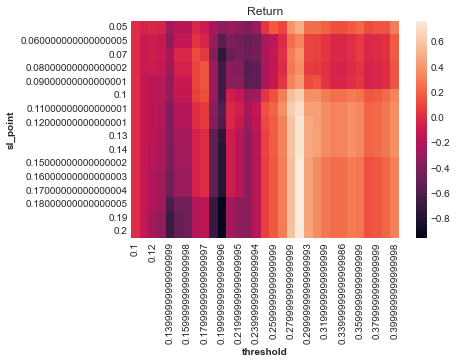

In [24]:
pic = optResult.pivot('sl_point', 'threshold', 'returns')
sns.heatmap(data = pic).set(title='Return')

[Text(0.5, 1.0, 'Calmar Ratio')]

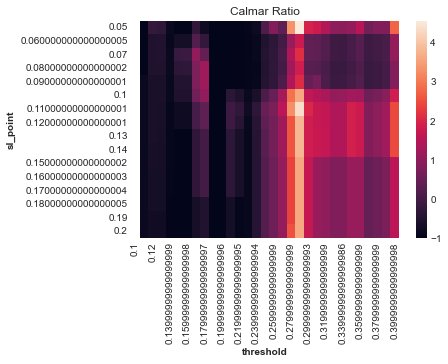

In [25]:
pic = optResult.pivot('sl_point', 'threshold', 'calmarRatio')
sns.heatmap(data = pic).set(title='Calmar Ratio')

 ## Out of sample

In [30]:
fund = 10000
money = 10000
feeRate = 0.0015
length = 20
times_of_std = 2
rule = '1D'

d1 = df_outofsample.resample(rule=rule, closed='right', label='right').first()[['open']]
d2 = df_outofsample.resample(rule=rule, closed='right', label='right').max()[['high']]
d3 = df_outofsample.resample(rule=rule, closed='right', label='right').min()[['low']]
d4 = df_outofsample.resample(rule=rule, closed='right', label='right').last()[['close']]
d5 = df_outofsample.resample(rule=rule, closed='right', label='right').sum()[['volume']]
df = pd.concat([d1,d2,d3,d4,d5], axis=1)

df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['shortSMA'] = df['close'].rolling(window = 13, center = False).mean()
df['longSMA'] = df['close'].rolling(window = 21, center = False).mean()

maxima_list = [0]
for i in range(len(df)):
    if df['close'][i] > df['close'][i-1]:
        maxima = df['close'][i]
    elif df['close'][i] < df['close'][i-1]:
        maxima = maxima
    maxima_list.append(maxima)
maxima_list = pd.DataFrame(maxima_list)
maxima_list = maxima_list.drop(0)
maxima_list = maxima_list.set_index(df.index)
df['maxima'] = maxima_list

minima_list = [0]
minima = df['close'][0]
for i in range(len(df)):
    if df['close'][i] < df['close'][i-1]:
        minima = df['close'][i]
    elif df['close'][i] > df['close'][i-1]:
        minima = minima
    minima_list.append(minima)
minima_list = pd.DataFrame(minima_list)
minima_list = minima_list.drop(0)
minima_list = minima_list.set_index(df.index)
df['minima'] = minima_list

In [31]:
upper_bound_list = [0]
lower_bound_list = [0]
BBW_list = [0]
threshold_list = [0]

for i in range(len(df)):
    upper_bound = df['ma'][i] + times_of_std * df['std'][i]
    upper_bound_list.append(upper_bound)

for i in  range(len(df)):
    lower_bound = df['ma'][i] - times_of_std * df['std'][i]
    lower_bound_list.append(lower_bound)

for i in range(len(df)):
    BBW = (upper_bound_list[i] - lower_bound_list[i]) / df['ma'][i]
    BBW_list.append(BBW)

for i in range(len(df)):
    threshold = 0.29
    threshold_list.append(threshold)

BBdata = pd.DataFrame([upper_bound_list, lower_bound_list, BBW_list, threshold_list])
BBdata = pd.DataFrame.transpose(BBdata)
BBdata.columns = ['upper_bound', 'lower_bound', 'BBW', 'threshold']

BBdata = BBdata.drop(0)
BBdata = BBdata.set_index(df.index)

In [32]:
rule = '1H'
df_hour = data.resample(rule = rule, closed = 'right', label = 'right').first()['open']
df_funding = pd.concat([df_hour, funding], axis = 1)
df_funding = df_funding.fillna(method = 'bfill', limit = 2).fillna(0)
df_funding

,open,rate
2020-12-31 16:00:00+00:00,28795.5,-0.000007
2020-12-31 17:00:00+00:00,28829.0,-0.000007
2020-12-31 18:00:00+00:00,28414.5,-0.000016
2020-12-31 19:00:00+00:00,28550.5,-0.000017
2020-12-31 20:00:00+00:00,28878.0,-0.000014
...,...,...
2022-07-30 12:00:00+00:00,23820.0,0.000007
2022-07-30 13:00:00+00:00,23966.0,0.000012
2022-07-30 14:00:00+00:00,24376.0,0.000013
2022-07-30 15:00:00+00:00,24490.0,0.000008


In [33]:
def fundingPayment(df_funding, side, unit, t1, t2):
    if len(df_funding.loc[t1:t2]) == 0:
        fee = 0
    else:
        funding_rate = np.array(df_funding.loc[t1:t2])
        fee = unit * np.dot(funding_rate[:,0], funding_rate[:,1])
    
    if side == 'long':
        return -fee
    elif side == 'short':
        return fee

                                profit    profitfee
startTime                                          
2022-03-01 00:00:00+00:00     0.000000     0.000000
2022-03-02 00:00:00+00:00     0.000000     0.000000
2022-03-03 00:00:00+00:00     0.000000     0.000000
2022-03-04 00:00:00+00:00     0.000000     0.000000
2022-03-05 00:00:00+00:00     0.000000     0.000000
...                                ...          ...
2022-07-27 00:00:00+00:00  1404.324258  1363.390351
2022-07-28 00:00:00+00:00  1404.324258  1363.390351
2022-07-29 00:00:00+00:00  1404.324258  1363.390351
2022-07-30 00:00:00+00:00  1404.324258  1363.390351
2022-07-31 00:00:00+00:00  1404.324258  1363.390351

[153 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

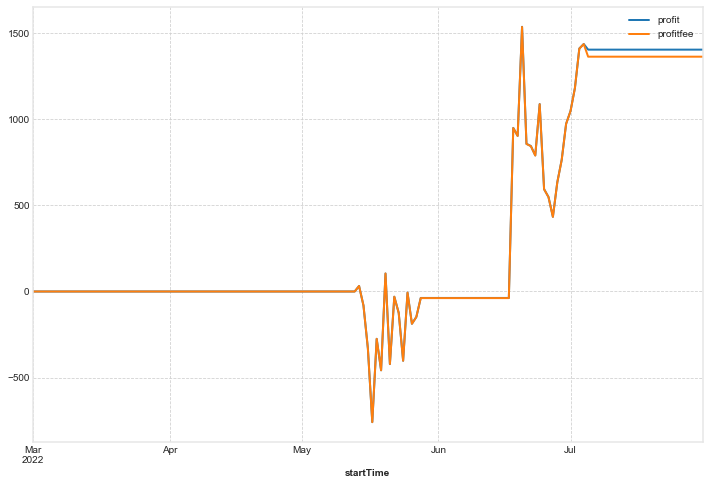

In [34]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
sl_point = 0.11

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] < df['longSMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
            t1 = df.index[i+1]
        
        if BBdata['BBW'][i-1] < BBdata['threshold'][i-1] and BBdata['BBW'][i] > BBdata['threshold'][i] and df['shortSMA'][i] > df['longSMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)
            t1 = df.index[i+1]

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'long', executeSize, df.index[t], t2)

        if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] < df['longSMA'][i] or df['close'][i] <= df['maxima'][i]*(1-sl_point) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)
        t2 = df.index[i+1]
        fundingFee = fundingPayment(df_funding, 'short', executeSize, df.index[t], t2)

        if (BBdata['BBW'][i-1] >= BBdata['threshold'][i-1] and BBdata['BBW'][i] < BBdata['threshold'][i]) or df['shortSMA'][i] > df['longSMA'][i] or df['close'][i] >= df['minima'][i]*(1+sl_point) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate + fundingFee
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            t1 = df.index[i+1]

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [35]:
print(buy)
print(short)
print(sell)
print(buytocover)

[]
[73, 108]
[]
[88, 126]


In [36]:
equity['equity_value'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity_value'] / equity['equity_value'].cummax()) - 1
equity['drawdown'] = equity['equity_value'] - equity['equity_value'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

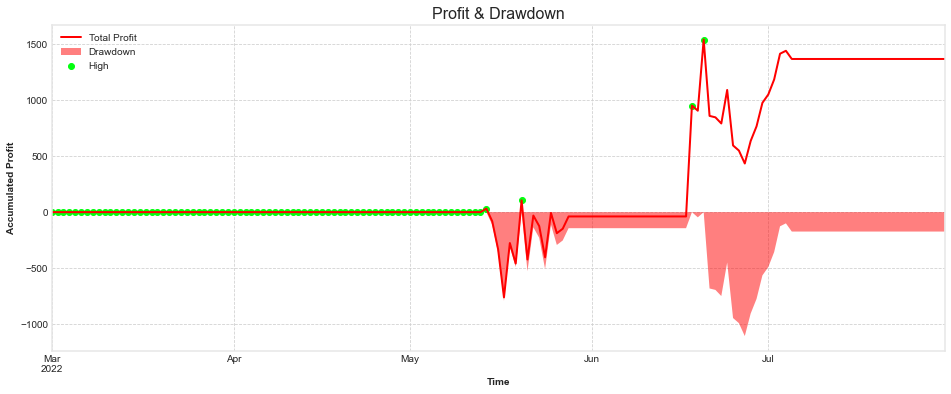

In [37]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16)

Text(0.5, 1.0, 'Price Movement')

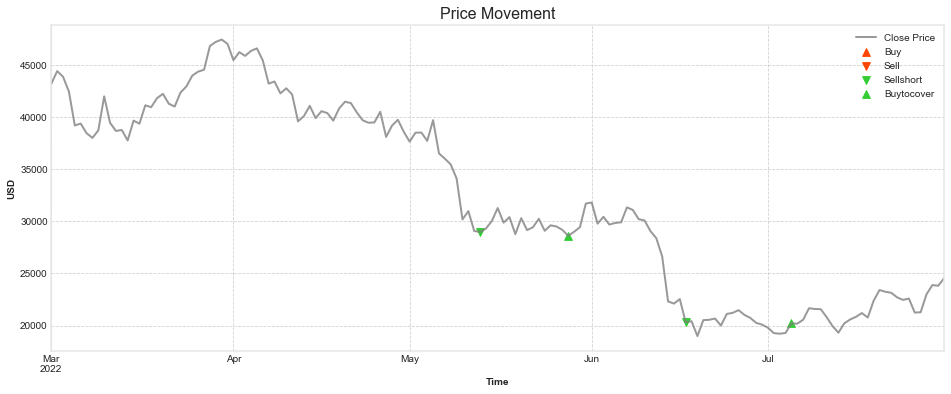

In [38]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16)

In [39]:
equity['unit_profit'] = profit_fee_list
daily_returns = [0]
for i in np.arange(1, len(equity), 1):
    dr = ((equity['equity_value'][i] - equity['equity_value'][i-1]) / equity['equity_value'][i-1])*100
    daily_returns.append(dr)
daily_returns = pd.DataFrame(daily_returns)
daily_returns = daily_returns.set_index(equity.index)
daily_returns.columns = ['daily_returns']
equity['daily_returns'] = daily_returns
equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
equity['downside_return'] = equity['downside_return'].fillna(0)

In [40]:
sqd_list = [0]
for i in np.arange(1, len(equity), 1):
    sqd = ((equity['daily_returns'][i] - np.mean(equity['daily_returns']))) ** 2
    sqd_list.append(sqd)
var = sum(sqd_list) / len(equity)
daily_vol = var ** 0.5
annual_vol = (252 ** 0.5) * daily_vol

equity['downside_return'] = equity['unit_profit'].loc[equity['unit_profit'] < 0]
equity['downside_return'] = equity['downside_return'].fillna(0)
equity['downside_return'] = equity['downside_return'] / fund
dssqd_list = [0]
for i in np.arange(1, len(equity), 1):
    dssqd = (equity['downside_return'][i] - np.mean(equity['downside_return'])) ** 2
    dssqd_list.append(dssqd)
dsvar = sum(dssqd_list) / len(equity)
daily_dsvol = dsvar ** 0.5
dsvol = (len(equity) ** 0.5) * daily_dsvol

In [41]:
profit = equity['profitfee'].iloc[-1] 
returns = (equity['equity_value'][-1] / equity['equity_value'][0]) - 1 ## cumulated return
mdd = abs(equity['drawdown_percent']).max() # mdd
calmarRatio = returns / mdd # risk return ratio
tradeTimes = len(buy) + len(short)
annual_returns = ((equity['equity_value'][-1] / 10000) ** (1 / (len(df) / 365)) - 1)*100
sharpe_ratio = annual_returns / annual_vol # sharpe ratio
sortino_ratio = returns / dsvol

In [42]:
print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}')
print(f'mdd: {np.round(mdd,4)}')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'annual_returns: {annual_returns}')
print(f'annual_volatility: {annual_vol}')
print(f'sharpe_ratio: {sharpe_ratio}')
print(f'sortino_ratio: {sortino_ratio}')

profit: $1363.39
returns: 0.1363
mdd: 0.0956
calmarRatio: 1.43
tradeTimes: 2
annual_returns: 35.650334305402744
annual_volatility: 24.92661768406198
sharpe_ratio: 1.4302114613888222
sortino_ratio: 1.180204743151987
